<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Classification Exercise

For this exercise, we'll use water pump data from DrivenData.org

Your goal is to predict the operating condition of a waterpoint for each record in the dataset.

It is a multiclass classification problem with `status_group` as the target class.

Take some time to read the data dictionary here: [https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25)

In [1]:
import pandas as pd

df = pd.read_csv("../assets/data/water_pumps.csv.gz")

#### 1: There are a lot of columns, so instead of performing the usual EDA on *all* columns, choose 3-4 columns to focus on and explore the data checking for (among other things):

- missing values
- strange values
- distributions and relationships in your data

In [2]:
# Which columbs do we intuitivley think could be a good source of prediction
select_cols =  ["construction_year", "extraction_type", "water_quality", "population","status_group"]

In [3]:
# Check to see size of dataframe:
# df.shape = 59400 rows, 41 columns
# Check to see what would happen if you dropped any row with a column that had a null value
# df.dropna(inplace=True) --> df.shape = 28k rows (i.e. has probably deleted too much data)

In [4]:
# Check to see if the selected columns have any null values that need to be dropped - none of them do
df[select_cols].isnull().sum()

construction_year    0
extraction_type      0
water_quality        0
population           0
status_group         0
dtype: int64

In [5]:
# Look at min / max etc. to understand strange values
df[select_cols].describe(include='all')
# Identifies that there are missing values in both the construction_year and population

,construction_year,extraction_type,water_quality,population,status_group
count,59400.000000,59400,59400,59400.000000,59400
unique,NaN,18,8,NaN,3
top,NaN,gravity,soft,NaN,functional
freq,NaN,26780,50818,NaN,32259
mean,1300.652475,NaN,NaN,179.909983,NaN
std,951.620547,NaN,NaN,471.482176,NaN
min,0.000000,NaN,NaN,0.000000,NaN
25%,0.000000,NaN,NaN,0.000000,NaN
50%,1986.000000,NaN,NaN,25.000000,NaN
75%,2004.000000,NaN,NaN,215.000000,NaN


In [6]:
# Only keep the data where the construction year data is present, likewise with population
df = df.loc[df["construction_year"] > 0, :]
df = df.loc[df["population"] > 0, :]

#### 2: how many rows are there in each class/label?

In [7]:
# A class or label is whether the pump is: 'functional', 'functional needs repair' or 'non functional'
df.groupby('status_group')['id'].agg(['count'])

,count
status_group,
functional,20709
functional needs repair,2499
non functional,14136


In [8]:
# Note, as the data currently stands there are categorical features which KNN model cannot deal with. 
# As with regression, these categorical features need to be translated into dummy features first

In [9]:
# Note, we need a suitable sample size for each category of a feature. So first have a look to see where this is not true
df.groupby('extraction_type')['id'].count().sort_values()

extraction_type
cemo                             1
other - mkulima/shinyanga        1
walimi                           2
climax                           8
other - play pump               50
windmill                        61
india mark iii                  63
other - swn 81                 175
other - rope pump              384
afridev                        969
ksb                           1036
mono                          1545
india mark ii                 1556
swn 80                        2129
nira/tanira                   2742
other                         3670
submersible                   3935
gravity                      19017
Name: id, dtype: int64

In [10]:
# Then 'clean' up the data to remove excessive sample errors by reducing the number of categories
df["extraction_type"].replace({'cemo': 'other',
                               'other - mkulima/shinyanga' : 'other',
                               'walimi': 'other',
                               'climax': 'other',
                               'other - play pump': 'other',
                               'windmill' : 'other',
                               'india mark iii' : 'india mark',
                               'india mark ii' : 'india mark',
                               'other - swn 81': 'swn 80/81',
                               'swn 80': 'swn 80/81',
                               'other - rope pump':'other'
                              }, inplace=True)

In [11]:
df.groupby('water_quality')['id'].count().sort_values()


water_quality
fluoride abandoned        9
milky                   136
salty abandoned         166
fluoride                167
coloured                224
unknown                1153
salty                  3300
soft                  32189
Name: id, dtype: int64

In [12]:
df["water_quality"].replace({'fluoride abandoned': 'fluoride',
                             'salty abandoned': 'salty',
                              }, inplace=True)

In [13]:
# Get dummy variables for the categorical features
df_with_dummies = pd.get_dummies(df.loc[:,select_cols], columns=['extraction_type', 'water_quality'], drop_first=True)
print (df_with_dummies.columns)
print (df_with_dummies.shape)

Index(['construction_year', 'population', 'status_group',
       'extraction_type_gravity', 'extraction_type_india mark',
       'extraction_type_ksb', 'extraction_type_mono',
       'extraction_type_nira/tanira', 'extraction_type_other',
       'extraction_type_submersible', 'extraction_type_swn 80/81',
       'water_quality_fluoride', 'water_quality_milky', 'water_quality_salty',
       'water_quality_soft', 'water_quality_unknown'],
      dtype='object')
(37344, 16)


#### 3: Do a train-test split. What is the make-up of the labels in your train and test sets?

In [14]:
from sklearn.model_selection import train_test_split

df = df_with_dummies

X_train, X_test, y_train, y_test = train_test_split(df.drop("status_group", axis=1),
                                                    df["status_group"],
                                                    test_size=0.3,
                                                    random_state=1)

print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

26140 11204
26140 11204


#### 4: Using your training set, obtain a basic KNN model's cross-validated accuracy

In [15]:
# Carry out a KNN model fit and prediction, not using any kFolds
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy_score(y_test, y_pred)

0.6461085326669047

#### 5: Look at the confusion matrix: where are the mistakes?

`cross_val_score` doesn't give us a predictor, so you may have to train one!

In [16]:
# This means that cross_val only gives you an error score of your model. 
# It doesn't actually tell you what the model is to run predictions from

In [17]:
# Calculate confusion matrix of predictions (rows), vs. outcomes (columns)
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[5066,   82, 1022],
       [ 521,   52,  202],
       [2089,   49, 2121]])

In [20]:
# conf_matrix / conf_matrix.sum(axis=1)
import numpy as np
cm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

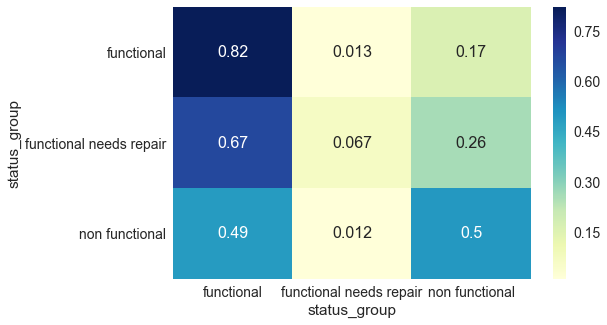

In [21]:
# Visualise the confusion matrix 
import seaborn as sbs
import matplotlib.pyplot as plt

array = cm
s = conf_matrix.shape[0]
#r = index=["stage 1", "stage 2", "stage 3"]
r = df.groupby('status_group').agg(['count']).index

df_cm = pd.DataFrame(array, index=r, columns=r)

plt.figure(figsize = (8,5))
sbs.set(font_scale=1.4)#for label size
sbs.heatmap(df_cm, cmap="YlGnBu", annot=True,annot_kws={"size": 16});# font size

In [20]:
# UPDATE MODEL TO INCLUDE A NUMBER OF K-FOLDS (i.e. cross validation)
# NOTE THIS IS THE MANUAL METHOD THAT ALLOWS YOU TO TRAIN A PREDICTOR (fancy term for get out a model)
from sklearn.model_selection import KFold

X = df.drop("status_group", axis=1)
y = df["status_group"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

K_fold_cv = KFold(n_splits=5, shuffle=True, random_state=42)

import numpy as np

# Set the fold count
i = 1
# Set the vehicle to store the models spun up from each fold
models ={}
scores = []

for train_index, test_index in K_fold_cv.split(X_train, y_train):
    print(f"Fold {i}", end="\t")
    i += 1
    
    X_train_local = X_train.iloc[train_index]
    y_train_local = y_train.iloc[train_index]
    
    # Reset the model each time, using KNeighborsClassifer as we are working with categorical data
    model = KNeighborsClassifier(n_neighbors=7)
    # Fit the model to the training fold
    model.fit(X_train_local, y_train_local)
    models[i] = model
    
    # Create a prediction for y based on the training fold test_index - this is the local test data, not the global
    y_pred = model.predict(X_train.iloc[test_index])
    acc = accuracy_score(y_train.iloc[test_index], y_pred)
    print (acc)
    scores.append(acc)
     
# Use Fold 5 (the best one) to predict the outcomes of the global test data
f_pred = models[5].predict(X_test)
f_pred

Fold 1	0.6447972456006121
Fold 2	0.6400153022188217
Fold 3	0.6373374139250191
Fold 4	0.6390589135424637
Fold 5	0.635424636572303


array(['functional', 'functional', 'non functional', ..., 'functional',
       'non functional', 'non functional'], dtype=object)

In [21]:
# Calculate mean accuracy score for model above with k=5 and KNeighborsClassifier(n_neighbors=7)
s = 0
for i in scores:
    s += i
s/len(scores)

0.639326702371844

In [22]:
# The quick way to do accuracy tests is with cv_scores, but then you can't extract the model (and the predictive power, as above)
# This checks the model is stable, and test n_neighbors, or right alpha for regularisation
from sklearn.model_selection import cross_val_score

model = KNeighborsClassifier(n_neighbors=7)

cv_scores = cross_val_score(model, X_train, y_train, cv=5)

print(cv_scores)
print(cv_scores.mean())

[0.64658635 0.62860968 0.63236419 0.63733741 0.64638347]
0.6382562192391881


#### 6: BONUS - obtain a better value for k using grid search - how much can you improve your score?

In [23]:
# This is meant to iterate through k nearest neighbors, not number of folds
grid = np.array(range(2, 10))
scores = []

def gridsearch(k, X_train_loc, y_train_loc):
    model = KNeighborsClassifier(n_neighbors=7)

    cv_scores = cross_val_score(model, X_train_loc, y_train_loc, cv=k)
    scores.append(cv_scores.mean())
    print(cv_scores.mean())
    
for k in grid:
    gridsearch(k, X_train, y_train)
    
# I.e. maximum score occurs when k = 5 and cv_score = 0.6414

0.6317901203617864
0.6391354289846635
0.6425021486336653
0.6382562192391881
0.6398238814913644
0.6400154447463126
0.6401688978503542
0.6407814422334953


#### 7: BONUS: what else can you do to improve your score?

Try:

- standardisation: to make KNN consider features equally
- stratification: to improve on the "representativeness" of your samples

In [24]:
# Stratification
df2 = df_with_dummies

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df2.drop("status_group", axis=1),
                                                            df2["status_group"],
                                                            test_size=0.3,
                                                            random_state=1,
                                                            stratify=y)

display(y_train_2.value_counts() / len(y_train_2))
display(y_test_2.value_counts() / len(y_test_2))

functional                 0.554552
non functional             0.378539
functional needs repair    0.066909
Name: status_group, dtype: float64

functional                 0.554534
non functional             0.378526
functional needs repair    0.066940
Name: status_group, dtype: float64

In [25]:
# Recheck what the best value of kFolds is for cross-validation, once stratify has been applied to the training data
scores = []
for k in grid:
    gridsearch(k, X_train_2, y_train_2)

# I.e. maximum score occurs when k = 9 and cv_score = 0.6418 (basically the same)

0.6252108335799456
0.6343918557330852
0.6337413706680765
0.6389824411042293
0.639518031030199
0.6407798031879953
0.6405128007334098
0.6417747562750956


In [26]:
# SCALING FEATURES TO BE NORMALLY DISTRIBUTED
df3 = df_with_dummies
from sklearn.preprocessing import StandardScaler

X3 = df3.drop("status_group", axis=1)
y3 = df3["status_group"]

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X3,
                                                    y3,
                                                    test_size=0.3,
                                                    random_state=1,
                                                    stratify=y3)
scaler = StandardScaler()

# NOTE - you should only transform continuous columns - so this is not good practice

X_train_transformed = scaler.fit_transform(X_train_3)
# do NOT fit the scaler on the test set! Use the already fit scaler from above!
X_test_transformed = scaler.transform(X_test_3)

In [27]:
# Recheck what the best value of kFolds is for cross-validation, once stratify
# AND scaling of features has been applied to the training data 
scores = []
for k in grid:
    gridsearch(k, X_train_transformed, y_train_3)

# I.e. maximum score occurs when k = 9 and cv_score = 0.668 (a couple of percent better than without scaling!)

0.6552411367150874
0.663312869388801
0.6656083471116144
0.6650343006845443
0.6647664996339727
0.6676355741824823
0.6660672028678418
0.6684773995891913


In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_transformed, y_train_3)
y_pred = knn.predict(X_test_transformed)
accuracy_score(y_test_3, y_pred)

0.667707961442342

# Things I should have done

In [31]:
# Should have done gridsearch to optimise for n_neighbors
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator=KNeighborsClassifier(),
                    param_grid={"n_neighbors": [3, 5, 7, 9]},
                    scoring="accuracy",
                    cv=3)

grid.fit(X_train, y_train)

print(grid.best_score_, grid.best_params_)

0.6395179801071156 {'n_neighbors': 9}
